# Initialisation

In [13]:
%load_ext autoreload
%autoreload 2

import os
path = os.getcwd().split(os.sep)
path = os.sep.join(path[:-1])
os.chdir(path)
import sys
sys.path.append(path)
here = "here "
print(here)
from functions.abc_smc import abc_smc
print(here + 'functions/abc_smc.py')
from functions.models import model_robin
print(here + 'functions/models.py')
from functions.kernels import Kernel_no_perm_RW, Kernel_trunc_RW
print(here + 'functions/kernels.py')
from functions.perm_abc_smc import perm_abc_smc, optimal_index_distance
print(here + 'functions/perm_abc_smc.py')
from functions.perm_abc_smc_os import perm_abc_smc_os
print(here + 'functions/perm_abc_smc_os.py')
import numpy as np
from jax import random, vmap, jit, lax
import jax.numpy as jnp
from scipy.optimize import linear_sum_assignment
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from functions.dataclass_Theta import Theta


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
here 
here functions/abc_smc.py
here functions/models.py
here functions/kernels.py
here functions/perm_abc_smc.py
here functions/perm_abc_smc_os.py


# Toy Model 

In [6]:
K = 10 
n_obs = 20
sigma_alpha, sigma_mu = 10, 10
model = model_robin(K = K, n_obs = n_obs, sigma_alpha= sigma_alpha, sigma_mu= sigma_mu)

key = random.PRNGKey(0)
key, key_theta, key_yobs = random.split(key, 3)
true_theta = model.prior_generator(key_theta, 1)
true_theta.loc[0,0,0] = 0.
true_theta.glob[0,0] = 0.
y_obs = model.data_generator(key_yobs, true_theta)
print("True theta: ", true_theta)

True theta:  Theta(loc=array([[[  0.       ],
        [ 21.891056 ],
        [ -1.6292391],
        [ -0.574461 ],
        [  4.99312  ],
        [  1.0972358],
        [-16.793629 ],
        [ -6.226515 ],
        [ -2.968302 ],
        [  7.779063 ]]], dtype=float32), glob=array([[0.]], dtype=float32))


# permABC-SMC

In [3]:
gen = random.PRNGKey(0)
alpha = .95
N = 1000
test_perm = perm_abc_smc(gen, model, N, 100.,  alpha, y_obs, Kernel_trunc_RW, Final_iteration= 10, verbose = 3)

N_perm_smc = np.sum(test_perm["N_sim"])
epsilon_smc_perm = test_perm["Eps_values"][-1]
mus_smc_perm = test_perm["Thetas"][-1].loc.squeeze()
alphas_smc_perm = test_perm["Thetas"][-1].glob.squeeze()

Distance Weights updated! (100.00% loc/ 0.00% glob)
In optimal index distance: zs min = -64.3 max = 59.0 matrices min = 0.116 max = 1.23e+03
Not smart version
Iteration 0: Epsilon = inf, ESS = 1000 Acc. rate = 100% Numb. unique particles = 1000
Std local: min = 5.29, max = 8.36 mean = 6.56
Std global: min = 12.6, max = 12.6 mean = 12.6
Proposed thetas loc min = -45.9 max = 53.6 glob min = -55.8 max = 53.3
Proposed zs min = -87.2 max = 75.4
In optimal index distance: zs min = -87.2 max = 75.4 matrices min = 0.102 max = 1.92e+03
Rate of smart (no change) acceptance = 78.11% (742/950)
In change, rate of acceptation = 13.46% (28/208) of rejection with change = 86.54% (180/208) and rejection with no change = 0.00% (0/208)
Index sum total = 950 Number of particles = 950
Index sum change = 208 Number of particles = 208
(950, 10, 1) (950,)
Acceptance rate = 26.53% Reject because ABC condition = 18.95% because ratio = 54.53%
Iteration 2: Espilon = 876.0485, ESS = 950 Acc. rate = 26.53% Uniquene

# ABC-Vanille

In [15]:
def ABC_table(key, model, y_obs, n_sim):
    key, key_theta, key_sim = random.split(key, 3)
    thetas = model.prior_generator(key_theta, n_sim)
    zs = model.data_generator(key_sim, thetas)
    distances = model.distance(zs, y_obs)
    print(distances.shape)
    return zs, thetas, distances

def permABC_table(key, model, y_obs, n_sim):
    key, key_theta, key_sim = random.split(key, 3)
    thetas = model.prior_generator(key_theta, n_sim)
    zs = model.data_generator(key_sim, thetas)
    dists, zs_index, _ = optimal_index_distance(zs, y_obs, model)
    zs = zs[np.arange(n_sim)[:,None],zs_index]
    thetas = thetas.apply_permutation(zs_index)
    return zs, thetas, dists
 

In [5]:
N_abc = int(N_perm_smc/K)
key = random.PRNGKey(0)
key, key_table = random.split(key)
zs_van, thetas_van, dists_van = ABC_table(key_table, model, y_obs, N_abc)

mus_van = thetas_van.loc.squeeze()
alphas_van = thetas_van.glob.squeeze()
indexes = np.argsort(dists_van)[:N]
epsilon_van = dists_van[indexes].max()
mus_van = thetas_van.loc[indexes].squeeze()
alphas_van = thetas_van.glob[indexes].squeeze()
print("Epsilon vanille =", epsilon_van)

(41662,)
Epsilon vanille = 159.686


# permABC-Vanille

In [6]:
N_permabc = int(N_perm_smc/K)
zs_perm_van, thetas_perm_van, dists_perm_van = permABC_table(key_table, model, y_obs, N_permabc)
mus_perm_van = thetas_perm_van.loc.squeeze()
alphas_perm_van = thetas_perm_van.glob.squeeze()
indexes_perm = np.argsort(dists_perm_van)[:N]
epsilon_perm_van = dists_perm_van[indexes_perm].max()  
mus_perm_van = thetas_perm_van.loc[indexes_perm,:].squeeze()
alphas_perm_van = thetas_perm_van.glob[indexes_perm,:].squeeze()
print("Epsilon perm vanille =", epsilon_perm_van)

In optimal index distance: zs min = -64.1 max = 66.6 matrices min = 0.0687 max = 1.46e+03
Epsilon perm vanille = 24.140305


# ABC-Gibbs

In [14]:
import numpy as np
from tqdm.notebook import tqdm
from jax import vmap, jit, random
import jax.numpy as jnp
from scipy import stats
from scipy.optimize import linear_sum_assignment

@jit
def distance_one_silo(x_k,y_k):
    return jnp.sum((x_k-y_k)**2)

@jit
def distance_all_silo(x,y):
    return vmap(distance_one_silo, in_axes=(0, 0))(x,y)
@jit
def distance_xs(xs, y):
    return vmap(distance_all_silo, in_axes=(0, None))(xs, y)

@jit
def distance_sum_silo(x,y):
    return jnp.mean((distance_all_silo(x,y)))

@jit
def distance_sum(xs, y):
    return (vmap(distance_sum_silo, in_axes=(0, None))(xs, y))
# @jit 
# def dist_full_y(xs, y):
#     return jnp.sum(vmap(dist_full, in_axes=(0, None))(xs, y), axis = 1)

def ABCmus(key, M, y_obs, alpha):
    key, key_mus, key_data = random.split(key, 3)
    mus = random.normal(key_mus, shape=(M,K))*model.sigma_mu
    thetas = Theta(loc = mus[:,:,None], glob = np.repeat([alpha], M)[:,None])
    xs = model.data_generator(key_data, thetas)
    dists = distance_xs(xs, y_obs)
    index_min = jnp.argmin(dists, axis=0)
    Eps_betas = jnp.array([dists[index_min[i],i] for i in range(K)])
    mus_min = np.array([mus[index_min[i],i] for i in range(K)])
    return mus_min, Eps_betas
    

def ABCalpha(key, M, y_obs, mus):
    key, key_alpha, key_data = random.split(key, 3)
    alphas = random.normal(key_alpha, shape=(M,1))*model.sigma_alpha
    thetas = Theta(loc = np.repeat([mus], M, axis=0)[:,:,None], glob = alphas)
    xs = model.data_generator(key_data, thetas)
    dists = distance_sum(xs, y_obs)
    index_min = jnp.argmin(dists)
    Eps_alpha = dists[index_min]
    alpha_min = alphas[index_min]
    return alpha_min[0], Eps_alpha



def gibbs_robin(key, T, M_mu, M_alpha, y_obs):
    mus = np.zeros((T+1,K))
    alphas = np.zeros(T+1)
    
    Eps_mu = np.zeros((T, K))
    Eps_alpha = np.zeros(T)
    
    key, key_alpha, key_mu = random.split(key, 3)
    mus[0] = random.normal(key_mu, shape=(K,))*model.sigma_mu
    alphas[0] = random.normal(key_alpha)*model.sigma_alpha
    for t in tqdm(range(T)):
        key, key_mus = random.split(key)
        mus[t+1], Eps_mu[t] = ABCmus(key_mus, M_mu, y_obs, alphas[t])
        key, key_alpha = random.split(key)
        alphas[t+1], Eps_alpha[t] = ABCalpha(key_alpha, M_alpha, y_obs, mus[t+1])
        
    return mus, alphas, Eps_mu, Eps_alpha 

In [15]:
# M = int(N_perm_smc/((N)*2*K))
print(model.sigma_alpha, model.sigma_mu, model.K, model.n_obs)
print(y_obs[0].shape)
M = 20
N = 1000
print(M)
mus_gibbs, alphas_gibbs, Eps_mus_gibbs, Eps_alphas_gibbs = gibbs_robin(key, N, M, M, y_obs[0])

10 10 10 20
(10, 20)
20


  0%|          | 0/1000 [00:00<?, ?it/s]

# PyMC 

In [16]:
import pymc as pm

# Define the model
with pm.Model() as mod:
    # Priors for unknown model parameters

    sigma_x = 1.0

    mu = pm.Normal('mu', mu=0, sigma=sigma_mu, shape=(K, 1))
    alpha = pm.Normal('alpha', mu=0, sigma=sigma_alpha, shape=(1, 1))

    # Likelihood (sampling distribution) of observations
    x = pm.Normal('x', mu=mu + alpha, sigma=sigma_x, observed=y_obs[0])

    # Inference
    trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha]
/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [17]:
true_post_mu = np.array(trace.posterior.mu[:,:,:,0]).reshape(4*1000, K)
true_post_alpha = np.array(trace.posterior.alpha).reshape(-1)

/Users/antoineluciano/.pyenv/versions/3.10.13/envs/jax_env/lib/python3.10/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'level'
  cset = contour_func(


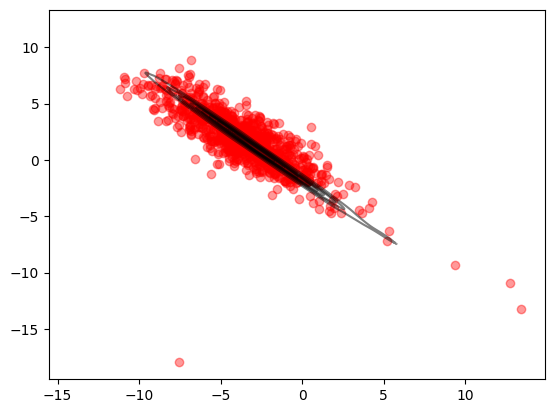

In [21]:
k = 2
sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black", alpha = .5)

plt.scatter(mus_gibbs[:,k], alphas_gibbs, alpha = .4, color = "red", label = "Gibbs")
# plt.scatter(mus_perm_smc[:,k], betas_perm_smc, alpha = .1, color = "blue", label = "Perm ABC SMC")
# sns.kdeplot(x=true_post_mu[:, k], y=true_post_alpha, label="True posterior", level = 3, color = "black")



Probleme permSMC ? Acc plus faible que OS et UM pour meme epsilon!!!

In [19]:
true_post_mu= np.array(trace.posterior.mu[:,:,:,0]).reshape(4*1000,K)
true_post_alpha = np.array(trace.posterior.alpha).reshape(-1)

# Comparison

## Marginals

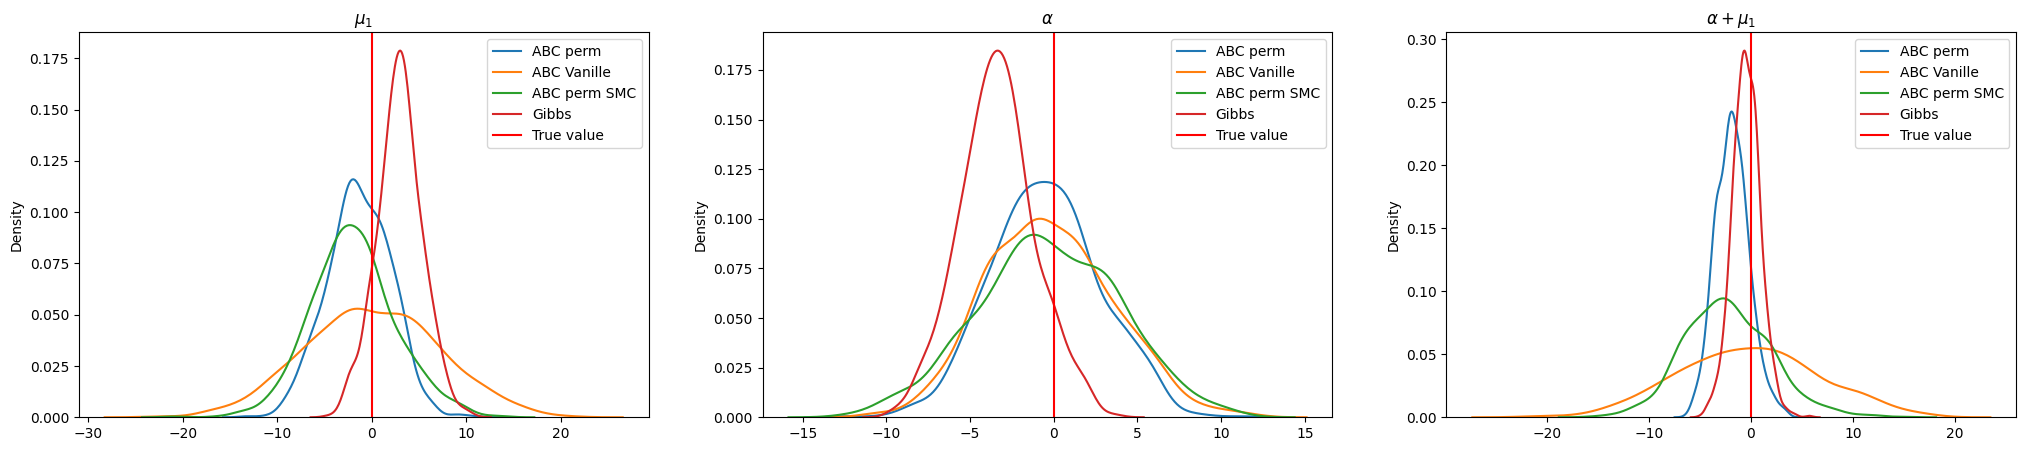

In [11]:
N_plot = 2
burnin = 5
f, ax = plt.subplots(1, 3, figsize=(25, 5))

sns.kdeplot(mus_perm_van[:,0], ax=ax[0], label='ABC perm')
sns.kdeplot(mus_van[:,0], ax=ax[0], label='ABC Vanille')
sns.kdeplot(mus_smc_perm[:,0], ax=ax[0], label='ABC perm SMC')
sns.kdeplot(mus_gibbs[burnin:,0], ax=ax[0], label='Gibbs')
ax[0].axvline(true_theta.loc[0,0], color='red', label='True value')
ax[0].set_title('$\mu_{1}$')

sns.kdeplot(alphas_perm_van, ax=ax[1], label='ABC perm')
sns.kdeplot(alphas_van, ax=ax[1], label='ABC Vanille')
sns.kdeplot(alphas_smc_perm, ax=ax[1], label='ABC perm SMC')
sns.kdeplot(alphas_gibbs[burnin:], ax=ax[1], label='Gibbs')
ax[1].axvline(true_theta.glob[0], color='red', label='True value')
ax[1].set_title('$\\alpha$')

sns.kdeplot(alphas_perm_van+mus_perm_van[:,0], ax=ax[2], label='ABC perm')
sns.kdeplot(alphas_van+mus_van[:,0], ax=ax[2], label='ABC Vanille')
sns.kdeplot(alphas_smc_perm+mus_smc_perm[:,0], ax=ax[2], label='ABC perm SMC')
sns.kdeplot(alphas_gibbs[burnin:]+mus_gibbs[burnin:,0], ax=ax[2], label='Gibbs')
ax[2].axvline(true_theta.glob[0]+true_theta.loc[0,0], color='red', label='True value')
ax[2].set_title('$\\alpha + \mu_{1}$')

for a in ax:
    a.legend()

plt.show()


## Joint

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


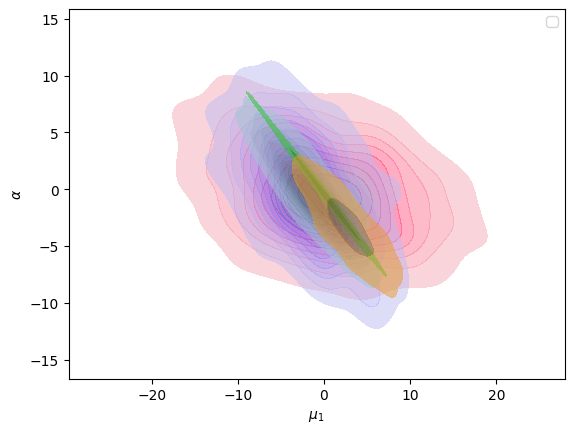

In [12]:
sns.kdeplot(x = mus_van[:, 0], y = alphas_van.squeeze(), label='ABC Vanille', color = "pink", alpha = .5, fill = True)
k = 0
sns.kdeplot(x = mus_smc_perm[:, 0], y = alphas_smc_perm, label='ABC SMC perm',  color = "darkblue", alpha =.5, fill = True)
sns.kdeplot(x = mus_perm_van[:, 0], y = alphas_perm_van.squeeze(), label='ABC Vanille perm', color = "lightblue", alpha = .5, fill = True)
sns.kdeplot(x = true_post_mu_k, y = true_post_alpha, label = "True", color = "green", alpha = .5, levels=3, fill = True)

# sns.kdeplot(x = mus_smc[:, k], y = alphas_smc, label='ABC SMC')
sns.kdeplot(x = np.array(mus_gibbs[:,0]), y = np.array(alphas_gibbs), label='ABC Gibbs', color ="orange", levels=3, fill = True, alpha = .5)
# plt.scatter(true_theta.loc[0,k], true_theta.glob[0], color='red', label='True value', marker = "x")
plt.ylabel("$\\alpha$")
plt.xlabel('$\mu_{'+str(1)+'}$')
plt.legend()


# True Posterior

In [13]:
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
import jax.random as random

def posterior_parameters(x, sigma_x, sigma_mu, sigma_alpha):
    """Calcule la moyenne et la covariance de la distribution postérieure."""
    K, n = x.shape
    x_bar = jnp.mean(x, axis=1)  # Moyenne empirique de chaque groupe
    
    # Variance et covariance des paramètres
    var_mu = sigma_x**2 / (n + sigma_x**2 / sigma_mu**2)
    var_alpha = sigma_x**2 / (K * n + sigma_x**2 / sigma_alpha**2)
    cov_mu_alpha = (sigma_x**2 / sigma_mu**2) / (n + sigma_x**2 / sigma_mu**2) * var_alpha
    
    # Matrice de covariance
    cov_matrix = jnp.eye(K+1) * var_mu
    cov_matrix = cov_matrix.at[K, K].set(var_alpha)
    cov_matrix = cov_matrix.at[:K, K].set(cov_mu_alpha)
    cov_matrix = cov_matrix.at[K, :K].set(cov_mu_alpha)
    
    # Moyenne postérieure
    mean_mu = (n * x_bar) / (n + sigma_x**2 / sigma_mu**2)
    mean_alpha = (n * jnp.sum(x_bar)) / (K * n + sigma_x**2 / sigma_alpha**2)
    mean_vector = jnp.concatenate([mean_mu, jnp.array([mean_alpha])])

    return mean_vector, cov_matrix

def posterior_pdf(x, mu_alpha, sigma):
    """Calcule la densité de probabilité de la loi normale postérieure."""
    return multivariate_normal.pdf(x, mean=mu_alpha, cov=sigma)

def sample_posterior(key, mean_vector, cov_matrix, num_samples=1):
    """Génère des échantillons depuis la postérieure en utilisant JAX."""
    samples = random.multivariate_normal(key, mean_vector, cov_matrix, shape=(num_samples,))
    return samples


# ABC-SMC

In [14]:
N = 1000
alpha = .95
key = random.PRNGKey(0)
test = abc_smc(key, model, N, 0, alpha, y_obs, Kernel_no_perm_RW, verbose = 3, Final_iteration = 30)

mus_smc= test["Thetas"][-1].loc.squeeze()
alphas_smc = test["Thetas"][-1].glob.squeeze()

AttributeError: 'Model' object has no attribute 'K'

# ABC-PMC

In [ ]:
from functions.abc_pmc import abc_pmc
thetas_pmc, weights_pmc, ess_pmc, epsilon_pmc, n_sim_pmc = abc_pmc(key = random.PRNGKey(0), model = model, n_particles = 20000, epsilon_target= epsilon_perm_van, alpha = .95, y_obs = sum_y, epsilon_1 = np.inf)
mus_pmc = thetas_pmc[-1].loc[:,:,0]
alphas_pmc = thetas_pmc[-1].glob[:,0]
w_pmc = weights_pmc[-1]

: 